Processing file: bartjhe-satudalamcinta.txt
Processing file: lastchild-duka.txt
Analysis complete. Results exported to output\lyrics_sentiment_analysis.xlsx


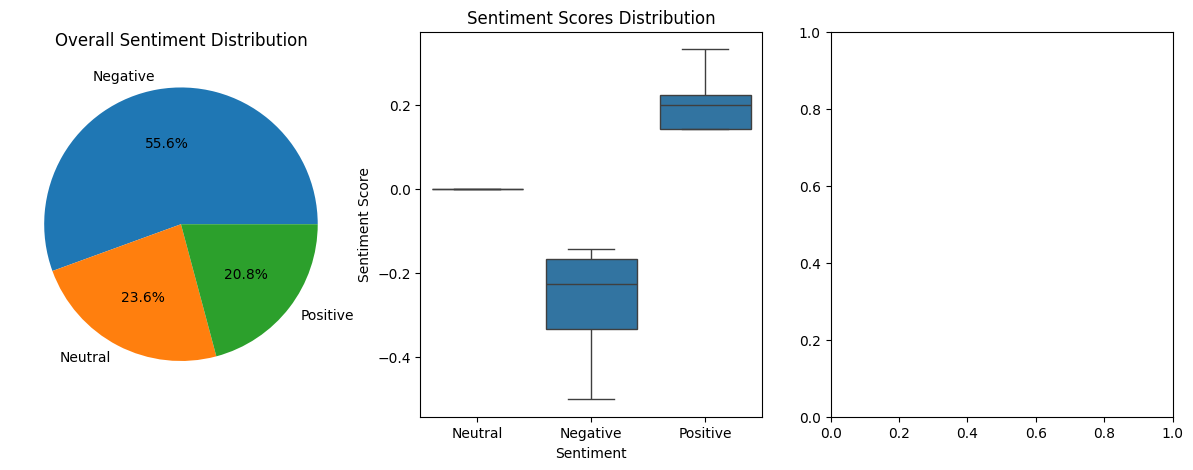

In [10]:
import os
import pandas as pd
import numpy as np
import re
import json
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s: %(message)s',
                    filename='indonesian_sentiment_analysis.log')

class IndonesianSentimentAnalyzer:
    def __init__(self, lexicon_path='leksikon'):
        """
        Initialize sentiment analyzer with Indonesian lexicon data
        """
        self.lexicon_path = lexicon_path
        self.positive_words = set()
        self.negative_words = set()
        self.booster_words = set()
        self.negation_words = set()
        
        self.load_lexicons()
    
    def load_lexicons(self):
        """
        Load various Indonesian lexicon files
        """
        try:
            # Load positive words
            pos_files = [
                os.path.join(self.lexicon_path, 'inset', 'positive.tsv'),
                os.path.join(self.lexicon_path, 'inset', '_json_inset-pos.txt')
            ]
            for pos_file in pos_files:
                if os.path.exists(pos_file):
                    with open(pos_file, 'r', encoding='utf-8') as f:
                        self.positive_words.update(self._read_lexicon_file(f))
            
            # Load negative words
            neg_files = [
                os.path.join(self.lexicon_path, 'inset', 'negative.tsv'),
                os.path.join(self.lexicon_path, 'inset', '_json_inset-neg.txt')
            ]
            for neg_file in neg_files:
                if os.path.exists(neg_file):
                    with open(neg_file, 'r', encoding='utf-8') as f:
                        self.negative_words.update(self._read_lexicon_file(f))
            
            # Load booster and negation words
            booster_file = os.path.join(self.lexicon_path, 'sentistrength_id', 'boosterwords_id.txt')
            negation_file = os.path.join(self.lexicon_path, 'sentistrength_id', 'negatingword.txt')
            
            if os.path.exists(booster_file):
                with open(booster_file, 'r', encoding='utf-8') as f:
                    self.booster_words = set(line.strip().lower() for line in f if line.strip())
            
            if os.path.exists(negation_file):
                with open(negation_file, 'r', encoding='utf-8') as f:
                    self.negation_words = set(line.strip().lower() for line in f if line.strip())
            
            logging.info(f"Loaded lexicons: {len(self.positive_words)} positive, {len(self.negative_words)} negative words")
        
        except Exception as e:
            logging.error(f"Error loading lexicons: {e}")
    
    def _read_lexicon_file(self, file):
        """
        Read lexicon file with various formats
        """
        words = set()
        for line in file:
            line = line.strip().lower()
            # Handle TSV and JSON-like formats
            if '\t' in line:
                word = line.split('\t')[0].lower()
            elif ':' in line:
                try:
                    word = json.loads(line.replace("'", '"')).get('word', '').lower()
                except:
                    word = line.split(':')[0].lower()
            else:
                word = line.lower()
            
            if word:
                words.add(word)
        return words
    
    def preprocess_text(self, text):
        """
        Preprocess Indonesian text
        """
        if not isinstance(text, str):
            return []
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-z\s]', '', text)
        
        # Split into words
        words = text.split()
        
        return words
    
    def analyze_sentiment(self, text):
        """
        Perform sentiment analysis on Indonesian text
        """
        if not isinstance(text, str) or text.strip() == '':
            return {
                'sentiment': 'Neutral',
                'sentiment_score': 0,
                'positive_count': 0,
                'negative_count': 0,
                'total_words': 0
            }
        
        # Preprocess text
        words = self.preprocess_text(text)
        
        # Count sentiments
        positive_count = sum(1 for word in words if word in self.positive_words)
        negative_count = sum(1 for word in words if word in self.negative_words)
        
        # Adjust for negation and booster words
        total_words = len(words)
        
        # Calculate sentiment score
        sentiment_score = (positive_count - negative_count) / (total_words + 1)  # Add 1 to avoid division by zero
        
        # Categorize sentiment
        if sentiment_score > 0.1:
            sentiment = 'Positive'
        elif sentiment_score < -0.1:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        
        return {
            'sentiment': sentiment,
            'sentiment_score': sentiment_score,
            'positive_count': positive_count,
            'negative_count': negative_count,
            'total_words': total_words
        }

def process_lyrics_file(file_path, sentiment_analyzer):
    """
    Process lyrics file, analyzing each line
    """
    try:
        # Extract artist and title from filename
        filename = os.path.basename(file_path)
        artist, title = filename.rsplit('-', 1)
        title = title.replace('.txt', '')
        
        # Read lyrics
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lyrics_lines = f.readlines()
        
        # Analyze each line
        results = []
        for i, line in enumerate(lyrics_lines, 1):
            line = line.strip()
            if line:
                sentiment_result = sentiment_analyzer.analyze_sentiment(line)
                results.append({
                    'Artist': artist,
                    'Title': title,
                    'Line Number': i,
                    'Lyrics Line': line,
                    'Sentiment': sentiment_result['sentiment'],
                    'Sentiment Score': sentiment_result['sentiment_score'],
                    'Positive Words': sentiment_result['positive_count'],
                    'Negative Words': sentiment_result['negative_count'],
                    'Total Words': sentiment_result['total_words']
                })
        
        return pd.DataFrame(results)
    
    except Exception as e:
        logging.error(f"Error processing {file_path}: {e}")
        return None

def perform_bulk_sentiment_analysis():
    """
    Perform sentiment analysis on all text files in input folder
    """
    # Initialize sentiment analyzer
    sentiment_analyzer = IndonesianSentimentAnalyzer()
    
    # Find text files in the input folder
    input_files = [f for f in os.listdir('input') if f.endswith('.txt')]
    
    if not input_files:
        logging.warning("No text files found in the input folder.")
        return
    
    # Prepare list to store results
    all_results = []
    
    # Process each input file
    for input_file in input_files:
        full_path = os.path.join('input', input_file)
        print(f"Processing file: {input_file}")
        
        # Process individual lyrics file
        result_df = process_lyrics_file(full_path, sentiment_analyzer)
        
        if result_df is not None:
            all_results.append(result_df)
    
    # Combine all results
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
        
        # Export to Excel
        output_file = os.path.join('output', 'lyrics_sentiment_analysis.xlsx')
        os.makedirs('output', exist_ok=True)
        
        with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
            # Full Results Sheet
            final_df.to_excel(writer, sheet_name='Full Results', index=False)
            
            # Sentiment Summary
            summary_df = final_df.groupby(['Artist', 'Title', 'Sentiment']).size().unstack(fill_value=0)
            summary_df['Total Lines'] = summary_df.sum(axis=1)
            summary_df['Positive %'] = (summary_df['Positive'] / summary_df['Total Lines'] * 100).round(2)
            summary_df['Negative %'] = (summary_df['Negative'] / summary_df['Total Lines'] * 100).round(2)
            summary_df['Neutral %'] = (summary_df['Neutral'] / summary_df['Total Lines'] * 100).round(2)
            summary_df.to_excel(writer, sheet_name='Sentiment Summary')
        
        # Visualizations
        create_visualizations(final_df)
        
        print(f"Analysis complete. Results exported to {output_file}")
    else:
        logging.warning("No results to export.")

def create_visualizations(df):
    """
    Create comprehensive visualizations
    """
    output_folder = 'output'
    os.makedirs(output_folder, exist_ok=True)
    
    # Create a PDF with multiple visualizations
    from matplotlib.backends.backend_pdf import PdfPages
    
    with PdfPages(os.path.join(output_folder, 'sentiment_visualizations.pdf')) as pdf:
        # 1. Overall Sentiment Distribution
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        sentiment_counts = df['Sentiment'].value_counts()
        plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
        plt.title('Overall Sentiment Distribution')
        
        # 2. Sentiment Score Distribution
        plt.subplot(1, 3, 2)
        sns.boxplot(x='Sentiment', y='Sentiment Score', data=df)
        plt.title('Sentiment Scores Distribution')
        
        # 3. Sentiment by Artist
        plt.subplot(1, 3, 3)
        artist_sentiment = df.groupby(['Artist', 'Sentiment']).size().unstack(fill_value=0)
        artist_sentiment.plot(kind='bar', stacked=True)
        plt.title('Sentiment Distribution by Artist')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        
        # Additional visualizations
        # Sentiment Score Violin Plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Sentiment', y='Sentiment Score', data=df)
        plt.title('Sentiment Score Distribution')
        pdf.savefig()
        plt.close()

def main():
    # Perform bulk sentiment analysis
    perform_bulk_sentiment_analysis()

if __name__ == '__main__':
    main()